In [57]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import time

#Scikit Learn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import  MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error



#TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Normalization
import keras_tuner as kt


%matplotlib inline

monster_df = pd.read_csv('../data/processed/Monster_modeling_df.csv')

monster_df.drop(columns={"Unnamed: 0", "Monster Name", "Size",'Type','Alignment'},axis=1, inplace=True)
monster_df.head()



,Traits,Reactions,Armor Class,Hit Points,Challenge,Proficiency Bonus,STR,DEX,CON,INT,...,chaotic good,chaotic neutral,lawful evil,lawful good,lawful neutral,neutral,neutral evil,neutral good,unaligned,total_stats
0,1,0,19,207,15.0,5,23,12,21,18,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,106
1,1,0,19,243,16.0,5,27,10,25,16,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,112
2,1,0,18,200,13.0,5,22,10,22,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86
3,1,0,15,90,5.0,3,14,20,14,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,70
4,0,0,12,19,0.5,2,16,14,14,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,69


In [2]:
#Input Variables: Size, Type, Environment, Alignment, CR(disguised as 4x player level)
#Output Variables: Stats, Saving Throws, Traits(barebones), Attack Bonus, Damage per Round, Reactions (y/n), Legendary Actions (y/n)

LinearRegression (and related)
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor (and related)

In [3]:
monster_df.columns

Index(['Traits', 'Reactions', 'Armor Class', 'Hit Points', 'Challenge',
       'Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA',
       'Legendary Actions', 'Attack_Bonus', 'Spell_Bonus', 'Spell_Save_DC',
       'WIS_SV', 'INT_SV', 'CHA_SV', 'STR_SV', 'DEX_SV', 'CON_SV', 'Arctic',
       'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill', 'Mountain', 'NA',
       'Swamp', 'Underdark', 'Underwater', 'Urban', 'Average_Damage_per_Round',
       'Damage Resistances', 'Damage Immunities', 'Condition Immunities',
       'Damage Vulnerabilities', 'Spellcaster', 'Magic Resistance',
       'Legendary Resistance', 'Regeneration', 'Undead Fortitude',
       'Pack Tactics', 'Damage Transfer', 'Angelic Weapons', 'Charge',
       'size_ordinal', 'aberration', 'beast', 'celestial', 'construct',
       'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid',
       'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment',
       'any chaotic alignment', 'any evil alignment', 

## MultOutput Machine Learning
Classic machine learning fails here since it generally maps multiple inputs to a single output. We could run independent regressions, predict each variable one at a time. This ignores correlations in the outputs however, so it isn't optimal.

We will try two methods: Random Forests with multioutput regressor and using Tensorflow Keras API

In [4]:
## Train Test Split

X_data = monster_df[['Coastal','Arctic','Desert','Forest','Grassland', 'Hill', 'Mountain', 'NA', 'Swamp', 'Underdark','Underwater', 'Urban','size_ordinal', 'aberration', 'beast','celestial', 'construct', 'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid', 'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment', 'any chaotic alignment', 'any evil alignment', 'any non-good alignment', 'any non-lawful alignment', 'chaotic evil', 'chaotic good', 'chaotic neutral', 'lawful evil', 'lawful good','lawful neutral', 'neutral', 'neutral evil', 'neutral good', 'unaligned','Challenge']]

y_data = monster_df[['Hit Points','Armor Class','Proficiency Bonus','STR','DEX','CON','WIS','INT','CHA', 'STR_SV','DEX_SV','CON_SV','WIS_SV','INT_SV','CHA_SV', 'Attack_Bonus','Average_Damage_per_Round','Legendary Actions', 'Damage Resistances', 'Damage Immunities', 'Condition Immunities', 'Damage Vulnerabilities', 'Legendary Resistance', 'Magic Resistance']]


feature_list = X_data.columns
target_list = y_data.columns

x_train, x_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.3,random_state=42)




## Linear Regression for Multioutput Regression

In [5]:
model = (LinearRegression())
model.fit(x_train, y_train)
print("Training Score: ", model.score(x_train, y_train))
print("Testing Score: ",model.score(x_test, y_test))
yhat_l = model.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_l))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_l))
scores = cross_val_score(model,X_data,y_data,cv=5)
print(scores.mean())

Training Score:  0.7137115581392551
Testing Score:  0.6056351821451139
Mean squared error: 50.46
Coefficient of determination: 0.61
0.5317739480983121


## k-Nearest Neighbors for Multioutput Regression

In [6]:
model_k = MultiOutputRegressor(KNeighborsRegressor())
model_k.fit(x_train, y_train)
print("Training Score: ", model_k.score(x_train, y_train))
print("Testing Score: ",model_k.score(x_test, y_test))
yhat_k = model_k.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_k))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_k))
scores = cross_val_score(model_k,X_data,y_data,cv=5)
print(scores.mean())


Training Score:  0.6909416913834311
Testing Score:  0.587280629588338
Mean squared error: 31.44
Coefficient of determination: 0.59
0.49103829885942335


## Multi Output Gradiant Boosting Regressor

In [7]:
model_g = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=75))
model_g.fit(x_train, y_train)
print("Training Score: ", model_g.score(x_train, y_train))
print("Testing Score: ",model_g.score(x_test, y_test))
yhat_g = model_g.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_g))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_g))
scores = cross_val_score(model_g,X_data,y_data,cv=5)
print(scores.mean())

Training Score:  0.887926294036876
Testing Score:  0.6792865316241952
Mean squared error: 21.79
Coefficient of determination: 0.68
0.6284217079524883


## Random Forest Regression

In [8]:
n_est = 50
max_depth = 15
model_R = RandomForestRegressor(n_estimators = n_est,max_depth = max_depth, random_state=0)
model_R.fit(x_train, y_train)
print("Training Score: ", model_R.score(x_train, y_train))
print("Testing Score: ",model_R.score(x_test, y_test))
yhat_r = model_R.predict(x_test)

baseline_MSE = mean_squared_error(y_test, yhat_r)
baseline_r2 = r2_score(y_test, yhat_r)

print("Mean squared error: %.2f" % baseline_MSE)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % baseline_r2)


Training Score:  0.9259184314148653
Testing Score:  0.6278197300510371
Mean squared error: 23.52
Coefficient of determination: 0.63


## More info on Random Forest Regressor


In [10]:
## Feature Importance
feature_list = X_data.columns
# Get numerical feature importances
importances = list(model_R.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: Challenge            Importance: 0.87
Variable: size_ordinal         Importance: 0.07
Variable: dragon               Importance: 0.01
Variable: unaligned            Importance: 0.01
Variable: Coastal              Importance: 0.0
Variable: Arctic               Importance: 0.0
Variable: Desert               Importance: 0.0
Variable: Forest               Importance: 0.0
Variable: Grassland            Importance: 0.0
Variable: Hill                 Importance: 0.0
Variable: Mountain             Importance: 0.0
Variable: NA                   Importance: 0.0
Variable: Swamp                Importance: 0.0
Variable: Underdark            Importance: 0.0
Variable: Underwater           Importance: 0.0
Variable: Urban                Importance: 0.0
Variable: aberration           Importance: 0.0
Variable: beast                Importance: 0.0
Variable: celestial            Importance: 0.0
Variable: construct            Importance: 0.0
Variable: elemental            Importance: 0.0
Variable:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Baseline TensorFlow model Keras
Rather than train_test, we will use keras's validation split & validation data in order to split before modeling and then monitor test accuracy during training

In [11]:
# Turn data into numpy arrays
X = np.array(X_data)
Y = np.array(y_data)

In [12]:
#feature normlization will happen as part of keras preprocessing layer : Normalization
normalizer =  Normalization(axis=-1)
normalizer.adapt(X)

normalized_data = normalizer(X)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 1.0000
mean: 0.0000


In [13]:
# simple test model
x_train = np.array(x_train)
model = Sequential([
    normalizer,
    Dense(units=24)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 44)               89        
 n)                                                              
                                                                 
 dense (Dense)               (None, 24)                1080      
                                                                 
Total params: 1,169
Trainable params: 1,080
Non-trainable params: 89
_________________________________________________________________


In [14]:
model.predict(x_test)

array([[-2.4946098 , -0.25490582,  0.6611234 , ..., -0.32255724,
        -0.6594318 ,  0.5155428 ],
       [ 0.43079168,  1.2653267 , -0.4963568 , ...,  0.94937783,
        -0.6530229 ,  0.5135398 ],
       [-0.95175666, -0.43467352,  0.42275295, ..., -0.92345107,
        -0.68453974, -1.1832728 ],
       ...,
       [-0.72634846,  1.5143772 ,  0.7302902 , ..., -1.2778054 ,
         0.99729943,  1.7610897 ],
       [ 1.438926  , -0.22335291, -1.5569938 , ...,  0.44491154,
        -1.8388588 , -0.7933414 ],
       [ 0.53413016,  0.21913487, -0.11190552, ...,  0.35367528,
         0.1792722 ,  0.43187246]], dtype=float32)

In [15]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [16]:
%%time
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose =0,
    validation_split = 0.2
)

CPU times: total: 4.72 s
Wall time: 3.92 s


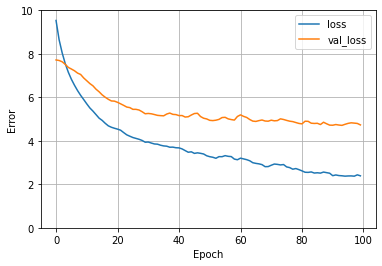

In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [19]:
model.evaluate(x_test,y_test,verbose=0)

5.114359378814697

In [33]:
def compile_model(n_inputs, n_outputs):
    model_tf = Sequential([
    normalizer])
    model_tf.add(Dense(20, input_dim = n_inputs, kernel_initializer = 'he_uniform', activation = 'relu'))
    model_tf.add(Dense(10, activation= "relu"))
    model_tf.add(Dense(5, activation= "relu"))
    model_tf.add(Dense(n_outputs))
    model_tf.compile(loss= "mean_squared_error" , optimizer="adam", metrics=['accuracy'])
    return model_tf
    

In [34]:
def cross_validate(X, y, K = 5, **kwargs):
    '''
    function adapted from yousefnami- towardsdatascience
    uses KFold validation to check that model works for different randomised conditions.
    '''
    scores = []
    histories = []
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model(44,24) # compile model
        start = time.time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]), # feed in the test data for plotting
                                   **kwargs).history)
        print(time.time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0)) # evaluate the test dataset
    print("average test loss: ", np.asarray(scores)[:,0].mean())
    print("average test accuracy: ", np.asarray(scores)[:,1].mean())
    print(model.summary())
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy', 'val_accuracy','val_loss']):
    """
    function adapted from yousefnami- towardsdatascience
    to plot the histories of data
    """
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].legend([i for i in range(len(histories))])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
                np.arange(max(history[metric]))
            )

In [46]:
#baseline model: average test loss:771, average test acc: 3.4%
scores, histories = cross_validate(X,Y)

9/9 [==============================] - 1s 25ms/step - loss: 838.4747 - accuracy: 0.0000e+00 - val_loss: 503.0925 - val_accuracy: 0.0000e+00
0.8490681648254395
9/9 [==============================] - 1s 24ms/step - loss: 703.4246 - accuracy: 0.0072 - val_loss: 1040.7506 - val_accuracy: 0.0000e+00
0.7650632858276367
9/9 [==============================] - 1s 26ms/step - loss: 821.9284 - accuracy: 0.0036 - val_loss: 593.4671 - val_accuracy: 0.0000e+00
0.7580645084381104
9/9 [==============================] - 1s 23ms/step - loss: 819.7354 - accuracy: 0.0287 - val_loss: 567.1981 - val_accuracy: 0.0145
0.7420618534088135
9/9 [==============================] - 1s 23ms/step - loss: 676.4110 - accuracy: 0.1577 - val_loss: 1153.2996 - val_accuracy: 0.1594
0.7410616874694824
average test loss:  771.561572265625
average test accuracy:  0.03478261008858681
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

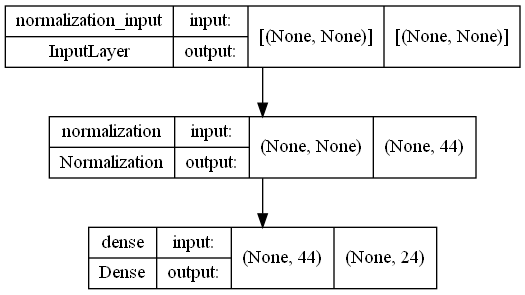

In [41]:
keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)

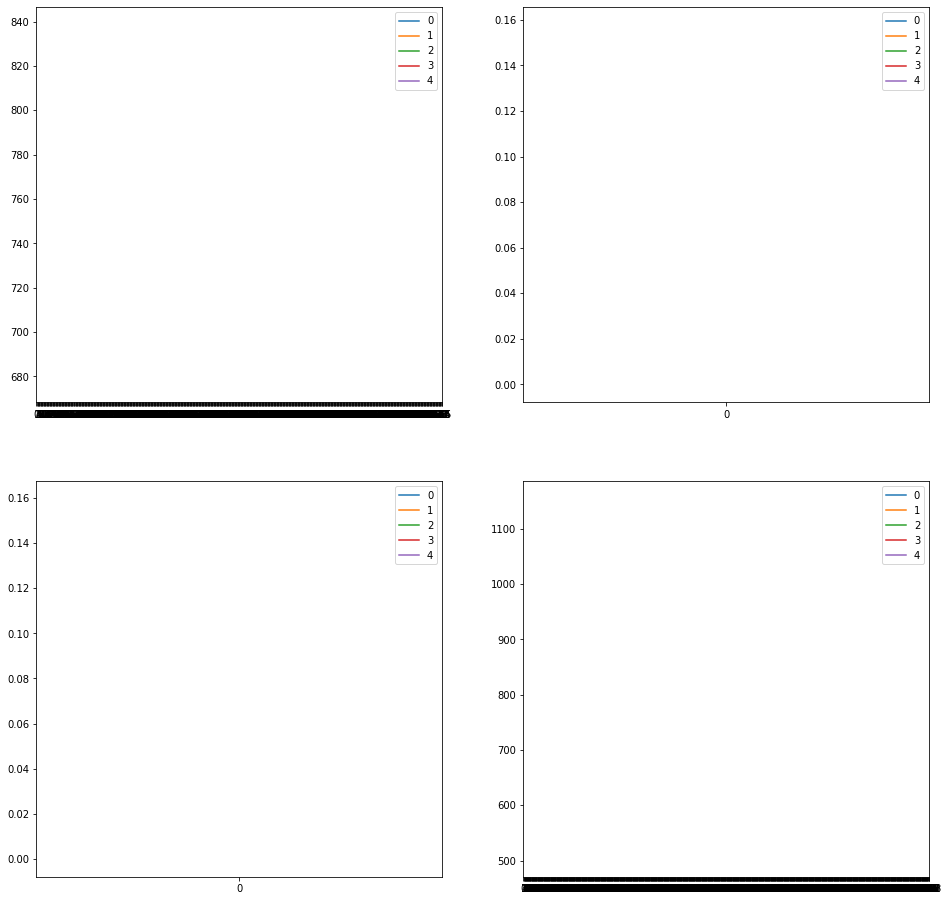

In [47]:
plot_histories(histories)

In [ ]:
#hyperparameter tuning

scores_tune, histories_tune = cross_validate(X,Y,epochs=50,verbose=0, batch_size=32)

## Model Tuning
Lets look at:
activation functio: relu and tanh
batch size: 16,32,64
epochs: 50, 100, 300
learning rate: 0.01, 0.001, and 0.0001


Trial #1: Epochs=100; Test Loss = 73.14, Test Acc = 78.7%, ~ 4-5 sec

Trial #2: Eppochs=300; Test Loss =68.48, Test Acc = 81.3%, ~12-13 sec

Trial #2: Epochs =50; Test Loss = 131.5, Test Acc = 77.6%, ~2-3 sec

Trial #4: Epochs = 50, bach_size=16; Test Loss = 91.9,  Test Accc = 77.9, ~3-4 sec

Trial # 5: """", batch_size =32


In [56]:
# Define the parameters to try out
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [50, 100,300],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [ ]:
model.save("monster_generator.h5")